<a href="https://colab.research.google.com/github/catastropiyush/Papers-in-100-Lines-of-Code/blob/main/Papers-in-100-Lines-of-Code/tree/main/Adam_a_Method_For_Stochastic_Optimization/Untitled41.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 5000/5000 [03:13<00:00, 25.90it/s]


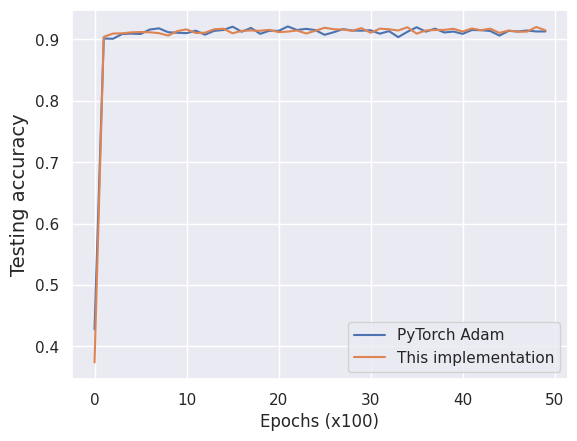

In [2]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from keras.datasets.mnist import load_data
sns.set_theme()

# load (and normalize) mnist dataset
(trainX, trainy), (testX, testy) = load_data()
trainX = np.float32(trainX) / 255
testX = np.float32(testX) / 255


class Adam:

    def __init__(self, model, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):

        self.model = model
        self.mt = [torch.zeros_like(p) for p in model.parameters()]
        self.vt = [torch.zeros_like(p) for p in model.parameters()]
        self.t = 0
        self.beta1 = beta1
        self.beta2 = beta2
        self.alpha = alpha
        self.epsilon = epsilon

    def zero_grad(self):
        for p in self.model.parameters():
            if p.grad is not None:
                p.grad = torch.zeros_like(p.grad)

    def step(self):

        self.t += 1

        self.mt = [self.beta1 * m + (1 - self.beta1) * p.grad for p, m in zip(model.parameters(), self.mt)]
        self.vt = [self.beta2 * v + (1 - self.beta2) * p.grad ** 2 for p, v in zip(model.parameters(), self.vt)]
        m_hat_t = [m / (1 - self.beta1 ** self.t) for m in self.mt]
        v_hat_t = [v / (1 - self.beta2 ** self.t) for v in self.vt]

        for p, m, v in zip(model.parameters(), m_hat_t, v_hat_t):
            p.data = p.data - self.alpha * m / (v.sqrt() + self.epsilon)


def train(model, optimizer, loss_fct=torch.nn.NLLLoss(), nb_epochs=5_000, batch_size=128):
    testing_accuracy = []
    for epoch in tqdm(range(nb_epochs)):

        # Sample batch
        indices = torch.randperm(trainX.shape[0])[:batch_size]
        x = trainX[indices].reshape(-1, 28 * 28)
        y = trainy[indices]

        log_prob = model(torch.from_numpy(x).to(device))
        loss = loss_fct(log_prob, torch.from_numpy(y).to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            # Testing
            model.train(mode=False)
            log_prob = model(torch.from_numpy(testX.reshape(-1, 28 * 28)).to(device))
            testing_accuracy.append(
                (log_prob.argmax(-1) == torch.from_numpy(testy).to(device)).sum().item() / testy.shape[0])
            model.train(mode=True)

    return testing_accuracy


if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    labels = ['PyTorch Adam', 'This implementation']
    for i, optim in enumerate([torch.optim.Adam, Adam]):
        model = torch.nn.Sequential(nn.Dropout(p=0.4), nn.Linear(28 * 28, 1200),
                                    nn.Dropout(p=0.4), nn.Linear(1200, 10),
                                    nn.LogSoftmax(dim=-1)).to(device)

        optimizer = optim(model if i == 1 else model.parameters())
        testing_accuracy = train(model, optimizer)
        plt.plot(testing_accuracy, label=labels[i])

    plt.legend()
    plt.xlabel('Epochs (x100)')
    plt.ylabel('Testing accuracy', fontsize=14)
    plt.savefig('adam.png', bbox_inches='tight')